# CAB420, Sequences, Example 1: Recurrent Neural Networks
Dr Simon Denman (s.denman@qut.edu.au)

# Overview

We've actually looked at a couple of methods for processing sequences already, though we didn't explicitly look at these in the context of working with sequential data. In summary:
* In week 3 when looking at classification, CAB420_Classification_Example_2_Multi_Class_Classification.ipynb explored classifying beer names. These are sequences of words, and to get this into a format we could work with we:
  * Used a word embedding model to tranform each word to a vector of some fixed size;
  * Concatenated all words in a beer name to obtain a feature;
  * Padded these features up to some length, and removed any long names, to ensure all beer names have the same length representation.
* In week 6 in the summary example CAB420_Summary_3_Text_Classification.ipynb, we used Bag-of-Words to transform our variable length phrase (in this case a tweet) into a fixed length histogram.
 
These two approaches haven't been that great in terms of performance, but perhaps more critically they also haven't really used/modelled the data as a "sequence". We'll now play with a recurrent neural networks, which will actually recieve and treat the data as a sequence.

## Too Long; Didn't Read:
* Recurrent Neural Networks are a type of neural network designed to operate over sequences
* Long Short Term Memory units are a type of RNN, that use an internal memory mechanism to keep track of what's happening in the sequence. This means that when processing the sequence, we keep track of what's happened so far, and pay attention to the temporal order of things
* With such networks, we can stack recurrent units like we do convolutional units, though we can run into problems with depth if we're not careful
* Ths usual rules for deep nets apply, we want lots of data, and need to be careful about overfitting

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pandas
import numpy
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

from keras.preprocessing.sequence import pad_sequences
import keras_nlp
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, GRU
from keras.utils import model_to_dot, plot_model

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

E0000 00:00:1748156036.945541     442 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748156036.949587     442 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## The Data

We're using the same data we used back in the earlier summary example - twitter data. We have 160,000 tweets that have been havested. For each of these, the tweet has been classified as either positive or negative.

Compared to what we did last time though, we'll be taking a few more samples as we're training a NN.

In [3]:
tweets = pandas.read_csv('../data/sentiment140/training.1600000.processed.noemoticon.csv')
print(tweets.head())

tweet_text = tweets.iloc[:, -1].tolist()
Y = numpy.array(tweets.iloc[:, 0])
Y[Y > 0] = 1

num_samples = 60000
train_samples = 50000
samples = numpy.random.choice(len(Y), num_samples)

train_X = [tweet_text[i] for i in samples[0:train_samples]]
train_Y = Y[samples[0:train_samples]]
test_X = [tweet_text[i] for i in samples[train_samples:]]
test_Y = Y[samples[train_samples:]]
print(numpy.shape(train_X))
print(numpy.shape(train_Y))
print(numpy.shape(test_X))
print(numpy.shape(test_Y))

   0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY _TheSpecialOne_  \
0  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   scotthamilton   
1  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY        mattycus   
2  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         ElleCTF   
3  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          Karoli   
4  0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY        joy_wolf   

  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  
0  is upset that he can't update his Facebook by ...                                                                   
1  @Kenichan I dived many times for the ball. Man...                                                                   
2    my whole body feels itchy and like its on fire                                                                    
3  @nationwideclass no, it's not behaving at all....           

### Data Preperation

We need to get our data into something numeric. Previously when we've played with text data, this has meant:
* text embeddings
* bag of words

We'll use an embedding again, but rather than use gensim and train one there, we'll build one as part of network. We still have some pre-processing to do though, and we'll do this through a tensorflow data object. We can use some keras functions to do all our pre-processing too, and we'll wrap that all up in a tensorflow dataset.

In [7]:
maxwords = 20000
batch_size = 64
# I don't expect to see tweets 96 words long, we we're not looking at words - we're looking at word parts.
sequence_length = 96

training_data_text = tf.data.Dataset.zip(tf.data.Dataset.from_tensor_slices(train_X),
                                         tf.data.Dataset.from_tensor_slices(train_Y))
testing_data_text = tf.data.Dataset.zip(tf.data.Dataset.from_tensor_slices(test_X),
                                        tf.data.Dataset.from_tensor_slices(test_Y))

# train a vocabulary on the words
# note here we're using word pieces - not whole words. This has become the standard approach
# for deep learning (see https://paperswithcode.com/method/wordpiece)
vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
    training_data_text.map(lambda x, y: x),
    vocabulary_size=maxwords,
    lowercase=True,
    strip_accents=True,
    split = True,
    reserved_tokens=["[PAD]", "[START]", "[END]", "[MASK]", "[UNK]"],)

# tokenizer layer. We could build this into our network, but we'll do it outside the network as part of our data
# pipeline
tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    # pass in the vocab that we train
    vocabulary=vocab,
    lowercase=True,
    strip_accents=True,
    oov_token="[UNK]",)

# a "packer" layer, that will "pack" our strings with a start and end token to denote the start and end of the string,
# and then pad strings to be a consistent length
packer = keras_nlp.layers.StartEndPacker(
    start_value=tokenizer.token_to_id("[START]"),
    end_value=tokenizer.token_to_id("[END]"),
    pad_value=tokenizer.token_to_id("[PAD]"),
    sequence_length=sequence_length,)

# pre-process function to wrap everything up, tokenize and pack strings
def preprocess(x, y):
    token_ids = packer(tokenizer(x))
    return token_ids, y

# apply pre-processing to data
# then set the batch size ready to pass into our networks
training_data_mapped = training_data_text.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).batch(batch_size)
testing_data_mapped = testing_data_text.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).batch(batch_size)

To make sure things are as we expect, we'll pull a batch from our dataset.

In [4]:
it = iter(training_data_mapped)
print(next(it))

(<tf.Tensor: shape=(64, 96), dtype=int32, numpy=
array([[   1,  330,  408, ...,    0,    0,    0],
       [   1,  450,  305, ...,    0,    0,    0],
       [   1,  907,  354, ...,    0,    0,    0],
       ...,
       [   1, 1600,   11, ...,    0,    0,    0],
       [   1,  787,   22, ...,    0,    0,    0],
       [   1,  584,  315, ...,    0,    0,    0]], dtype=int32)>, <tf.Tensor: shape=(64,), dtype=int64, numpy=
array([1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0])>)


We can see that we now have fixed length tokenized vectors.

## A Recurrent Neural Network
We're going to set this up much like our other networks, just with a couple of changes to the layers. The noteable difference are:
* Our input is now a sequence. In fact we won't even supply a dimension, we'll let the network infer that from the generator
* Rather than having our usual array of convolutional layers, we instead have an LSTM (long short-term memory) layer 

Note here that our first layer here is an embedding layer, which is where we'll learn the embedding that we want to use. This will be applied to each word part that we've pulled out.

In [5]:
inp = keras.Input(shape=(None,), dtype="int32")
x = Embedding(input_dim=maxwords, output_dim=128)(inp)
x = LSTM(64)(x)
x = Dense(32, activation='relu')(x)
out = Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inp, outputs=out)
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'], jit_compile=False)
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,611,521 (9.96 MB)

 Trainable params: 2,611,521 (9.96 MB)

 Non-trainable params: 0 (0.00 B)

None


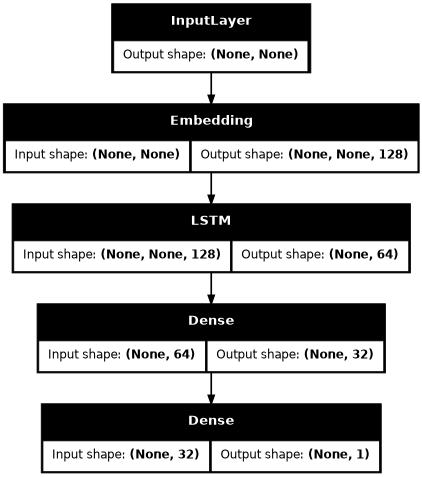

In [6]:
plot_model(model, show_shapes=True, dpi=60)

We'll train the network now, same approach as usual, though on different runs through this you may see some odd behaviours. I'm letting this train for 30 epochs, which is longer than it should need, but sometimes you'll see the network sit and stall for a while and spend a bunch of epochs hovering about 50%, and then it will suddenly start to figure it out and take off.

This is a problem with LSTMs and in particular working with long sequences, as the LSTM has to backpropogate through all these timesteps to try and learn something. As a result, learning can sometimes take a little while to get going. To counter this, I've got an early stopping callback in place so that if training does get going quickly, I don't end up overfitting too badly. To avoid this just stopping when nothing is learnt, I've also set this to only turn on at epoch 10.

In [7]:
model.fit(training_data_mapped,
          epochs=30,
          validation_data=testing_data_mapped, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=10)])

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.5022 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5033 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5021 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6941
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5040 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5074 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5042 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5031 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4990 - loss: 0.6933 - val_accuracy: 0.

Now we can evaluate the model, and we see that it works pretty well.

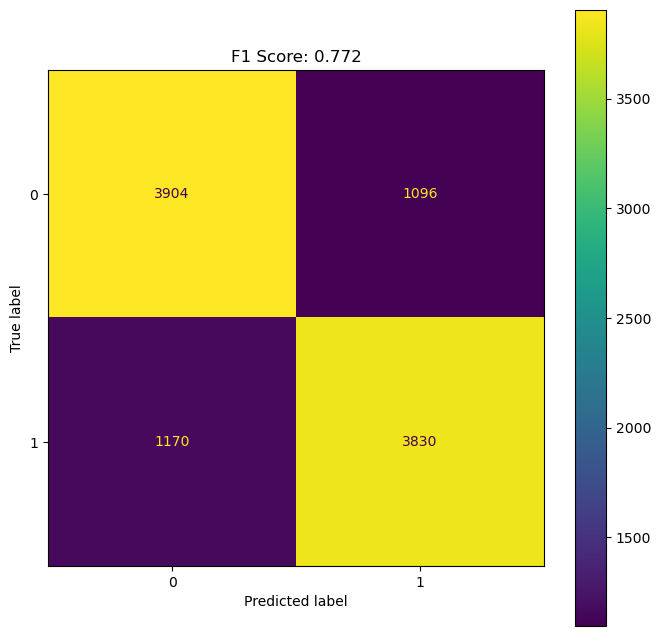

In [8]:
def eval_model(model, x_test, y_test):  
    
    # make predictions
    pred = model.predict(x_test, verbose=False);
    # apply threshold, just pick 0.5
    pred = pred >= 0.5

    # get confusion matrix and F1
    cm = confusion_matrix(y_test, pred)
    fig = plt.figure(figsize=[8, 8])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(2))
    c.plot(ax = ax)    
    ax.set_title("F1 Score: %1.3f" % f1_score(y_test, pred))

# pull out TF dataset as a numpy array to make it easy to get F1 Score and Confusion Matrix
test_tokens = []
test_labels = []

for i, (x, y) in enumerate(testing_data_mapped.as_numpy_iterator()):
    test_tokens.extend(x)
    test_labels.extend(y)
    
test_tokens = numpy.array(test_tokens)
test_labels = numpy.array(test_labels)

# evaluate
eval_model(model, test_tokens, test_labels)

## Stacking LSTMs

With CNNs we could (usually, to a point) get better performance by stacking convolutional layers, learning increasingly rich features. We can do the same thing with LSTMs. The one thing we need to do for this is make sure that the early LSTM layers are producing a sequence output. This means that they learn an intermediate sequence representation, which then goes to another LSTM that outputs a final embedding, which we can then classify.

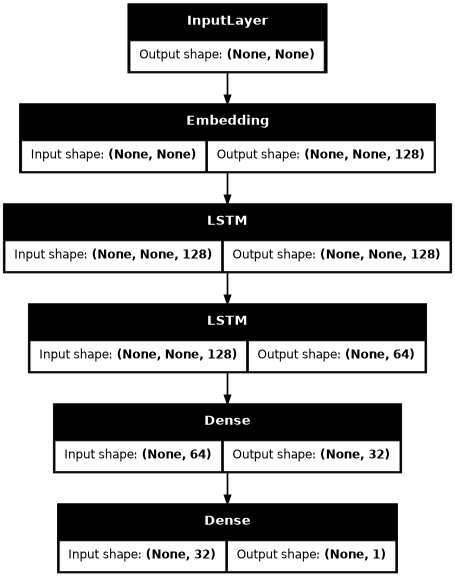

In [12]:
inp = keras.Input(shape=(None,), dtype="int32")
x = Embedding(input_dim=maxwords, output_dim=128)(inp)
x = LSTM(128, return_sequences=True)(x)
x = LSTM(64, return_sequences=False)(x)
x = Dense(32, activation='relu')(x)
out = Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inp, outputs=out)

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'], jit_compile=False)
plot_model(model, show_shapes=True, dpi=60)

In [13]:
model.fit(training_data_mapped,
          epochs=30,
          validation_data=testing_data_mapped, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=10)])

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.5053 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5047 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5039 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5028 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5009 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5018 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5018 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5017 - loss: 0.6931 - 

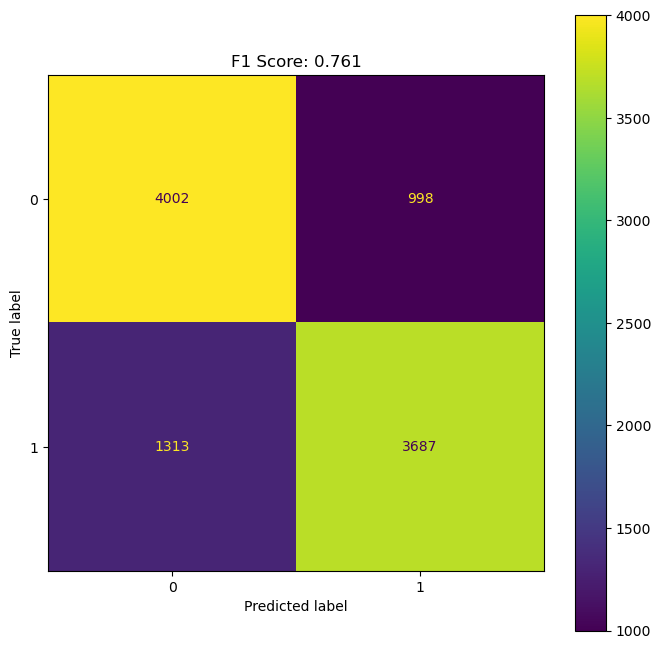

In [14]:
eval_model(model, test_tokens, test_labels)

## Final Thoughts

RNNs, and LSTMs, are neural networks designed to process sequences. Importantly, when they process a sequence they consider each element in the sequence in turn, thus taking note of the order of the data.

Like CNNs, we can stack recurrent layers to extract higher order information from the data, however like CNNs we can go too deep and make it hard for the model to learn. In general, we use far fewer recurrent layers than we do convolutional layers.

In this example we've also limited ourselves to sequences of the same length, i.e. we've padded seqeunces to get a fixed length. We actually don't have to do this. While this makes our code much simpler, with recurrent networks we can use variable length sequences, which may better reflect the actual data in some instances. The problem though, and why we haven't done that, is that having variable length sequences makes batching inputs through the network very inefficient. We've also got a workaroud for this, in the use start, end, and pad tokens. In theory, our network should learn to recognise this, and thus be able to ignore all the padded stuff at the end that it doesn't need.